In [59]:
%%capture

!pip install yfinance
!pip install pyspark

In [60]:
import yfinance as yf
import pyspark.sql.functions as f
from pyspark.sql.window import Window


def calculate_performance(dataframe):
    dataframe = dataframe.withColumn("ID", f.monotonically_increasing_id())

    w = Window().partitionBy().orderBy("ID")

    dataframe = dataframe.withColumn("Performance",
                                     (f.col("close") - f.lag("close", 1).over(w)) / f.lag("close", 1).over(w))
    dataframe = dataframe.withColumn("Performance", f.round("Performance", 5)).drop("ID")

    return dataframe


def download_stock_data(spark, stock, period, interval):
    print("Downloading " + stock +
          " stock data. Period: " + period +
          " Interval: " + interval)

    data = yf.download(stock, period=period, interval=interval)
    data['DateTime'] = data.index
    data = data[data["DateTime"] > "1970-01-01"]  # Fix Overflow error from mktime
    dataframe = spark.createDataFrame(data)
    dataframe = calculate_performance(dataframe)

    return dataframe


def write_stock_data(spark, dataframe, stock, period, interval):
    dataframe.write.format("parquet").mode("overwrite").save("../data/stocks/" + stock +
                                                             "_period=" + period +
                                                             "_interval=" + interval +
                                                             ".parquet")
    write_stock_log(spark, stock, period, interval)


def read_stock_data(spark, stock, period, interval):
    return spark.read.load("../data/stocks/" + stock +
                           "_period=" + period +
                           "_interval=" + interval +
                           ".parquet")


def write_stock_log(spark, stock, period, interval):
    try:
        df = spark.read.load("../data/stock_inventory.parquet")
        if df.filter(df.Stock == stock).count() > 0:
            df_to_write = df.withColumn("Last_Update",
                                        f.when(df.Stock == stock,
                                               f.date_format(f.current_timestamp(),
                                                             "dd/MM/yyyy HH:mm")).otherwise(
                                            df.Last_Update))
            print("Log Updated " + stock +
                  "_period=" + period +
                  "_interval=" + interval + "\n")

        else:
            new_row = spark.createDataFrame(
                [[stock, period, interval]],
                ["Stock", "Period", "Interval"])
            new_row = new_row.withColumn("Last_Update", f.date_format(f.current_timestamp(), "dd/MM/yyyy HH:mm"))
            df_to_write = df.union(new_row)

            print("Log Created " + stock +
                  "_period=" + period +
                  "_interval=" + interval + "\n")

    except:
        df_to_write = spark.createDataFrame(
            [[stock, period, interval]],
            ["Stock", "Period", "Interval"])

        df_to_write = df_to_write.withColumn("Last_Update", f.date_format(f.current_timestamp(), "dd/MM/yyyy HH:mm"))
        print("Log Created")

    df_to_write.write.format("parquet").mode("overwrite").save("../data/temp/stock_inventory.parquet")
    df = spark.read.load("../data/temp/stock_inventory.parquet")
    df.write.format("parquet").mode("overwrite").save("../data/stock_inventory.parquet")


def read_stock_log(spark):
    return spark.read.load("../data/stock_inventory.parquet")


def write_portfolio_list(spark, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date):
    try:
        df = spark.read.load("../data/portfolio_inventory.parquet")
        id_count = df.select("ID").rdd.max()[0] + 1
        new_row = spark.createDataFrame(
            [[id_count, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date]],
            ["ID", "Stock_List", "Number_Shares_List", "Buy_Dates_List", "Performance_List", "Min_Date", "Max_Date"])
        df_to_write = df.union(new_row)

    except:
        df_to_write = spark.createDataFrame(
            [[1, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date]],
            ["ID", "Stock_List", "Number_Shares_List", "Buy_Dates_List", "Performance_List", "Min_Date", "Max_Date"])

    df_to_write.write.format("parquet").mode("overwrite").save("../data/temp/portfolio_inventory.parquet")
    df = spark.read.load("../data/temp/portfolio_inventory.parquet")
    df.write.format("parquet").mode("overwrite").save("../data/portfolio_inventory.parquet")


def read_portfolio_list(spark):
    return spark.read.load("../data/portfolio_inventory.parquet")


In [61]:
import math
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd

plt.style.use('fivethirtyeight')


def build_model_LSTM():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(200, return_sequences=True),
        tf.keras.layers.LSTM(200, return_sequences=False),
        tf.keras.layers.Dense(50),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    return model

def build_model_GRU():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(100, return_sequences=True, activation='tanh'),
        tf.keras.layers.GRU(100, return_sequences=False, activation='tanh'),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    return model


def train_model(df, model):
    df = df.toPandas()
    data = df.filter(['Close'])
    dataset = data.values

    training_data_len = math.ceil(len(dataset) * 0.8)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model.fit(x_train, y_train, batch_size=1, epochs=2)

    test_data = scaled_data[training_data_len - 60:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(predictions - y_test) ** 2)

    print("\n*** RSME:" + str(rmse))

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train'])


def get_prediction(df, model):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = df.toPandas()
    data = df.filter(['Close'])

    last_60_days = data[-60:].values

    last_60_days_scaled = scaler.fit_transform(last_60_days)
    x_test = [last_60_days_scaled]
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    pred_price = scaler.inverse_transform(pred_price)

    return pred_price


def save_model_weights(model, stock, period, interval):
    model.save_weights('../model_weights/stocks/' + stock + "_period=" + period + "_interval=" + interval + '.h5')


def load_model_weights(model, stock, period, interval):
    return model.load_weights(
        '../model_weights/stocks/' + stock + "_period=" + period + "_interval=" + interval + '.h5')


def save_model_weights_portfolio(model, stock, id_portfolio):
    model.save_weights('../model_weights/portfolios/' + stock + "_portfolio=" + str(id_portfolio) + '.h5')


def load_model_weights_portfolio(model, stock, id_portfolio):
    model.load_weights('../model_weights/portfolios/' + stock + "_portfolio=" + str(id_portfolio) + '.h5')


def train_portfolio(spark, df_portfolio, id_portfolio):
    model = build_model()

    stock_close_prices = {}

    stock_list = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Stock_List").rdd.flatMap(lambda x: x).collect()[0]
    min_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Min_Date").rdd.flatMap(lambda x: x).collect()[0]
    max_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Max_Date").rdd.flatMap(lambda x: x).collect()[0]

    for stock in stock_list:
        print("\n*** Training model for stock: " + stock)
        df_stock = read_stock_data(spark, stock, "max", "1d")
        df_stock = df_stock.filter(df_stock.DateTime > min_date) \
            .filter(df_stock.DateTime < max_date)

        stock_close_prices[stock] = df_stock.select("Close")

        train_model(df_stock, model)
        print("\n*** Saving weights of model for stock: " + stock)
        save_model_weights_portfolio(model, stock, id_portfolio)


def predict_portfolio(spark, df_portfolio, id_portfolio):
    model = build_model()
    model.build(input_shape=(1, 60, 1))

    stock_close_prices = {}
    predicted_next_prices = {}

    stock_list = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Stock_List").rdd.flatMap(lambda x: x).collect()[0]
    min_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Min_Date").rdd.flatMap(lambda x: x).collect()[0]
    max_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Max_Date").rdd.flatMap(lambda x: x).collect()[0]

    for stock in stock_list:
        df_stock = read_stock_data(spark, stock, "max", "1d")
        df_stock = df_stock.filter(df_stock.DateTime > min_date) \
            .filter(df_stock.DateTime < max_date)

        stock_close_prices[stock] = df_stock.select("Close")

    for stock in stock_close_prices:
        print("\n*** Loading weights for stock: " + stock + " Portfolio: " + str(id_portfolio))
        load_model_weights_portfolio(model, stock, id_portfolio)
        print("*** Getting prediction for " + stock + " Portfolio: " + str(id_portfolio))
        predicted_next_prices[stock] = get_prediction(stock_close_prices[stock], model).tolist()[0][0]

    print("\n*** Predicted values for the stocks of your portfolio: ")
    for key, value in predicted_next_prices.items():
        print(key + ": " + str(value))
    print()


In [62]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[1]") \
        .appName("AI_Trading") \
        .getOrCreate()

In [63]:
df = download_stock_data(spark, "TSLA", "10y", "1d")

[*********************100%***********************]  1 of 1 completed


In [64]:
model_LSTM = build_model_LSTM()

In [65]:
model_GRU = build_model_GRU()

In [66]:
df = df.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [67]:
df = df.set_index('DateTime')

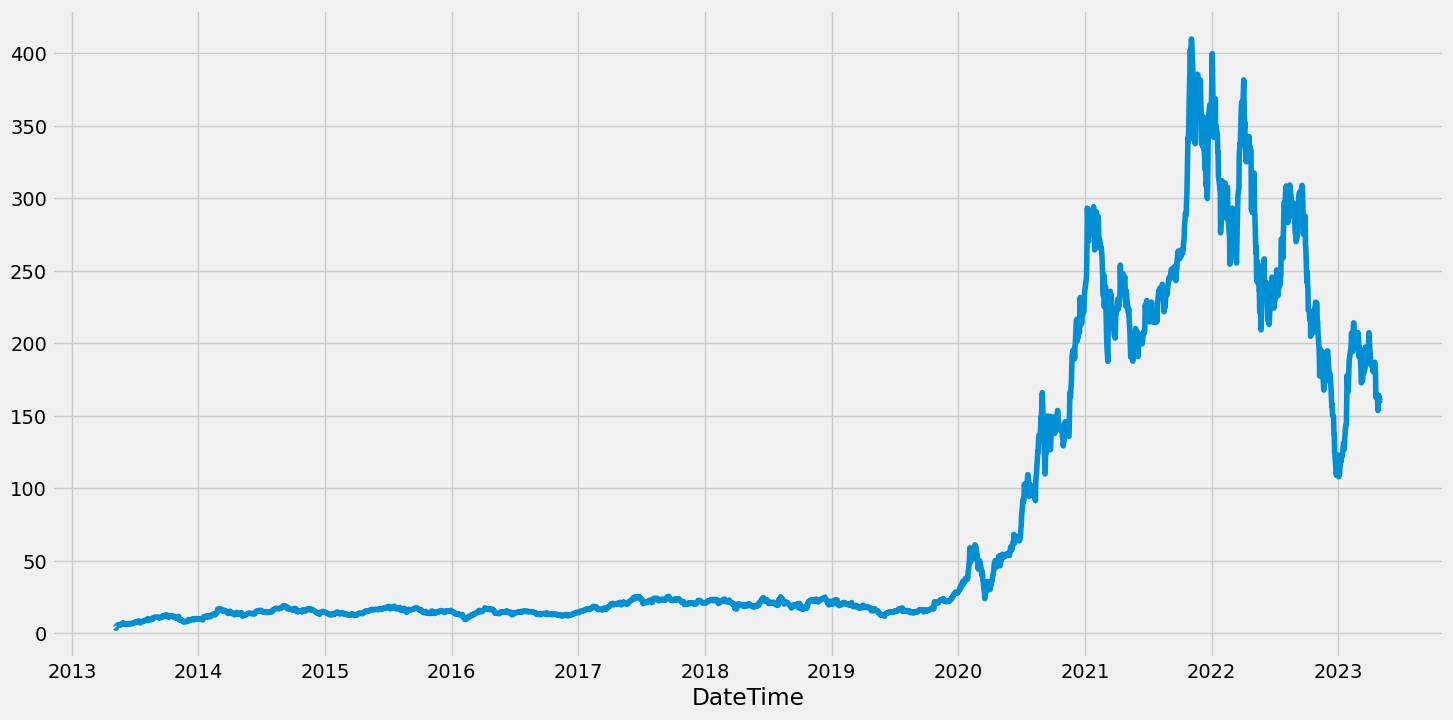

In [68]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('DateTime')
plt.show()

In [69]:
data = df.filter(['Close'])
dataset = data.values

In [70]:
dataset

array([[  3.96666694],
       [  3.7006669 ],
       [  3.71933293],
       ...,
       [160.30999756],
       [160.61000061],
       [160.8999939 ]])

In [71]:
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

2015

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[6.54738150e-04],
       [0.00000000e+00],
       [4.59449616e-05],
       ...,
       [3.85481545e-01],
       [3.86219979e-01],
       [3.86933775e-01]])

In [73]:
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

In [74]:
for i in range(100, len(train_data)):
    x_train.append(train_data[i - 100:i, 0])
    y_train.append(train_data[i, 0])

In [75]:
x_train[0]

array([6.54738150e-04, 0.00000000e+00, 4.59449616e-05, 2.27927643e-03,
       3.48701197e-03, 5.29861821e-03, 4.55034637e-03, 4.81289890e-03,
       6.02884093e-03, 5.90576939e-03, 5.64978135e-03, 5.26415846e-03,
       5.20672594e-03, 6.10760657e-03, 6.82141866e-03, 8.99567267e-03,
       8.06033346e-03, 8.11284467e-03, 6.93300205e-03, 6.08463380e-03,
       6.45384723e-03, 6.54081584e-03, 6.86572338e-03, 7.63532951e-03,
       7.30877997e-03, 6.39313070e-03, 6.92807956e-03, 7.00192154e-03,
       7.34980420e-03, 7.66158277e-03, 7.85685663e-03, 8.06853878e-03,
       7.40723673e-03, 7.22673267e-03, 7.54507572e-03, 7.69440286e-03,
       8.23919669e-03, 8.81845027e-03, 8.50831136e-03, 1.01197224e-02,
       1.02247448e-02, 9.80137938e-03, 1.05972376e-02, 1.08466623e-02,
       1.11485959e-02, 1.09549640e-02, 1.15030407e-02, 1.22070078e-02,
       1.17737986e-02, 8.78563252e-03, 1.06234955e-02, 1.04232968e-02,
       1.05299601e-02, 1.09812197e-02, 1.10320900e-02, 1.08614298e-02,
      

In [76]:
y_train[0]

0.021845934604221757

In [77]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [78]:
x_train.shape

(1915, 100)

In [79]:
y_train.shape

(1915,)

In [80]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [81]:
x_train.shape[0]

1915

In [82]:
x_train.shape[1]

100

In [83]:
x_train[0]

array([[6.54738150e-04],
       [0.00000000e+00],
       [4.59449616e-05],
       [2.27927643e-03],
       [3.48701197e-03],
       [5.29861821e-03],
       [4.55034637e-03],
       [4.81289890e-03],
       [6.02884093e-03],
       [5.90576939e-03],
       [5.64978135e-03],
       [5.26415846e-03],
       [5.20672594e-03],
       [6.10760657e-03],
       [6.82141866e-03],
       [8.99567267e-03],
       [8.06033346e-03],
       [8.11284467e-03],
       [6.93300205e-03],
       [6.08463380e-03],
       [6.45384723e-03],
       [6.54081584e-03],
       [6.86572338e-03],
       [7.63532951e-03],
       [7.30877997e-03],
       [6.39313070e-03],
       [6.92807956e-03],
       [7.00192154e-03],
       [7.34980420e-03],
       [7.66158277e-03],
       [7.85685663e-03],
       [8.06853878e-03],
       [7.40723673e-03],
       [7.22673267e-03],
       [7.54507572e-03],
       [7.69440286e-03],
       [8.23919669e-03],
       [8.81845027e-03],
       [8.50831136e-03],
       [1.01197224e-02],


In [84]:
x_train.shape

(1915, 100, 1)

In [85]:
y_train.shape

(1915,)

In [ ]:
model_LSTM.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1702/1915 [=========================>....] - ETA: 4s - loss: 0.0037

In [ ]:
test_data = scaled_data[training_data_len - 100:, :]
test_data

In [ ]:
len(test_data)

In [ ]:
x_test = []
y_test = dataset[training_data_len:, :]

In [ ]:
for i in range(100, len(test_data)):
    x_test.append(test_data[i - 100:i, 0])

x_test = np.array(x_test)

In [ ]:
len(x_test[0])

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape

In [ ]:
predictions = model_LSTM.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions.shape

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)

In [ ]:
print("\n*** RSME:" + str(rmse))

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('DateTime', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train'])

In [ ]:
last_100_days = test_data[len(test_data)-100:]

In [ ]:
last_100_days.shape

In [ ]:
last_100_days = np.reshape(last_100_days, (1, last_100_days.shape[0], 1))

In [ ]:
last_100_days.shape

In [ ]:
next_day = model_LSTM.predict(last_100_days)

In [ ]:
next_day.shape

In [ ]:
next_day

In [ ]:
last_100_days = np.append(last_100_days, next_day)

In [ ]:
last_100_days

In [ ]:
max = np.max(last_100_days)
min = np.min(last_100_days)
mean = np.mean(last_100_days)

In [ ]:
pct_up = max / mean

In [ ]:
pct_down = min / mean

In [ ]:
pct_rand = np.random.uniform(low=pct_down, high=pct_up)

In [ ]:
pct_rand

In [ ]:
max = np.max(last_100_days)
min = np.min(last_100_days)
mean = np.mean(last_100_days)
print(max)
print(min)
print(mean)
pct_up = max/mean
pct_down = min/mean
print(pct_up)
print(pct_down)
pct_rand = 1+ np.random.uniform(low=pct_down, high=pct_up)/100
print(pct_rand)

In [ ]:
last_100_days = test_data[len(test_data)-100:]

resultados = []
for i in range(10):
  resultados.append(last_100_days)

for j in range(10):
  for i in range(50):
    resultados[j] = np.reshape(resultados[j], (1, resultados[j].shape[0], 1))
    next_day = model_LSTM.predict(resultados[j])
    print("next day " + str(scaler.inverse_transform(next_day)))
    max = np.max(resultados[j])
    min = np.min(resultados[j])
    mean = np.mean(resultados[j])
    print("max " + str(max))
    print("min " + str(min))
    print("mean " + str(mean))
    pct_up = max/mean
    pct_down = min/mean
    print("pct_up " + str(pct_up))
    print("pct_down " + str(pct_down))
    pct_rand = 1 + ((1 if np.random.randint(2) == 0 else -1) * np.random.uniform(low=pct_down, high=pct_up)/10)
    print("pct_rand " + str(pct_rand))
    next_day = next_day * pct_rand
    print("next day append " + str(scaler.inverse_transform(next_day)))
    resultados[j] = np.append(resultados[j], next_day)

In [ ]:
resultados_ = scaler.inverse_transform(resultados)

for i in resultados_:
  plt.plot(i)



In [ ]:
print(resultados_)